In [2]:
# Imports
import numpy as np
import numpy.linalg as nplin
import numpy.random as npran
import scipy as sp
import scipy.linalg as splin
import scipy.stats as spstat
import matplotlib.pyplot as plt
import inspect
import requests
from __future__ import division

import glmnet
reload(glmnet)
import knockoffGLM as ko
reload(ko)       # as I update it
import simulate as sim
reload(sim)

# show pyplots in the notebook
%matplotlib inline

#### Generate Variables

In simulate.py, I have a few functions to generate X and y. 

genXy_normal_X_beta is on lines 41-54. 

In this case, both X is standard normal matrix with n=100 and 10 null predictors. y is a random bernouli vector, independent of X, with probability .2.

In [3]:
X,y = sim.genXy_normal_X_beta(seed=None,n=100,p1=0,pnull=10,base_prob=.25,beta_sd=1)

#### Initialize Model

I've created a class called knockoff_logit which contains the knockoff matrix, fit glmnet model, and the w statistic. The code is in knockoffGLM.py starting on line 57. 

First, it is initialized with y and X and the sort of knockoff desired. The original X and y can be retrieved with self.X and self.y respectively.

In [5]:
kologit = ko.knockoff_logit(y,X,knockoff='equicor')

In [10]:
kologit.y

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0])

In [14]:
kologit.X

array([[ -2.52011584e-02,   5.79696094e-02,   5.53128297e-02,
          1.42984520e-01,   1.79952190e-01,   1.23181564e-01,
          2.30425577e-01,   5.86180103e-02,   9.38158267e-02,
         -1.95060226e-01],
       [ -9.78495873e-02,   6.61152067e-02,  -7.62011783e-02,
         -1.78956488e-02,  -3.38035915e-02,  -5.85930116e-03,
          1.56787120e-02,   1.27003810e-03,  -1.73301712e-01,
          1.25194061e-01],
       [ -5.85348839e-02,   1.01427038e-01,  -4.64451565e-02,
          5.03180638e-02,   8.64343230e-02,   1.32789555e-01,
         -3.01240343e-02,   1.01428492e-01,  -1.27252022e-02,
         -1.02284915e-01],
       [  7.78708264e-03,   4.30052824e-02,  -2.87262952e-03,
         -1.04193738e-01,   7.95173006e-02,  -6.09918895e-02,
          2.62275737e-01,   5.29078215e-02,  -9.88427577e-02,
          8.06851689e-02],
       [  2.70880789e-02,   3.88612171e-02,  -1.23638427e-01,
         -7.76584119e-02,   7.20618424e-02,   5.80045406e-02,
         -4.52076323e-03

#### Generate knockoff, fit model, get z and w

From here, there are several internal functions which need to be run:

1) Create the knockoff, done with either self._create_SDP() on lines 66-89 in knockoffGLM.py, or self._create_equicor() in lines 91-111 of the same. The knockoff matrix is stored in self.X_ko.

2) Fit the lognet model and get the coefficient matrix, done with self._fit_lognet in lines 113-126. The coefficient matrix is stored in self.coef_matrix

3) Generate the z values for the original X and the knockoff, done with self._get_z() in lines 128-131. The z values are in self.z_value, and the index at which they entered, from largest to smallest lambda, is in self.z_rank

4) Generate the w values, done with self._get_w() in lines 133-137. The w values are in self.w_value, and the index of the lambda each entered at, times the sign, is in self.w_rank

There is a final function, self.fit(), in lines 139-144, which just runs these four commands.

In [6]:
kologit.fit()

In [12]:
# The knockoff
kologit.X_ko

array([[  1.77514852e-02,  -3.32502652e-01,  -6.03013744e-02,
          2.19398205e-01,   4.55713296e-02,   5.01283270e-03,
         -5.52444885e-02,  -2.04470450e-02,  -8.19328316e-03,
          3.58185171e-02],
       [  5.65466971e-02,  -8.02954434e-02,   6.47145581e-02,
         -9.19283776e-02,   5.55374892e-02,   7.41706497e-02,
         -3.18817219e-02,  -2.54834125e-03,   8.27525206e-02,
          2.22759462e-03],
       [  2.30279675e-01,  -1.29466990e-01,  -2.70136698e-02,
          9.57347881e-02,  -7.28820477e-02,   1.52866132e-01,
          2.33912757e-01,   1.72036646e-01,  -3.42861290e-02,
         -1.93093892e-01],
       [  9.91851071e-02,   7.29559742e-02,   2.70539527e-02,
         -1.22106052e-01,  -6.21597402e-02,  -2.22843399e-01,
         -1.61792827e-01,  -9.14438585e-03,  -6.84797519e-03,
          3.08401921e-02],
       [ -2.24102179e-02,   6.67476096e-02,   3.18684353e-01,
          1.60038337e-02,  -1.14454667e-01,  -2.50888147e-02,
         -5.25007470e-02

In [15]:
# The first 10 are the originals, last ten the knockoffs
kologit.z_value

array([ 0.00607354,  0.00349109,  0.00543683,  0.00295676,  0.00543683,
        0.00163796,  0.00618669,  0.00349109,  0.00099511,  0.00564128,
        0.00564128,  0.0094586 ,  0.00382861,  0.00105177,  0.0004028 ,
        0.0105663 ,  0.00204407,  0.00362237,  0.00389993,  0.00236932])

In [17]:
kologit.z_rank

array([ 31,  61,  37,  70,  37, 102,  30,  61, 129,  35,  35,   7,  56,
       126, 178,   1,  90,  59,  55,  82])

In [8]:
kologit.w_value

array([ 0.00607354, -0.0094586 ,  0.00543683,  0.00295676,  0.00543683,
       -0.0105663 ,  0.00618669, -0.00362237, -0.00389993,  0.00564128])

In [16]:
kologit.w_rank

array([ 31,  -7,  37,  70,  37,  -1,  30, -59, -55,  35])

#### Examine Knockoff
We know that the knockoffs and the original variables aren't coming in at exactly the same time, even when the X are normal. So, I took a look at the knockoff variables with a QQ plot. Red are the knockoffs and blue the original, with the black line representing a theoretical normal. 

As you can see, most of the knockoffs are not normally distributed, even if they have the same mean and covariances. I'm guessing that this explains the persistant differences we see.

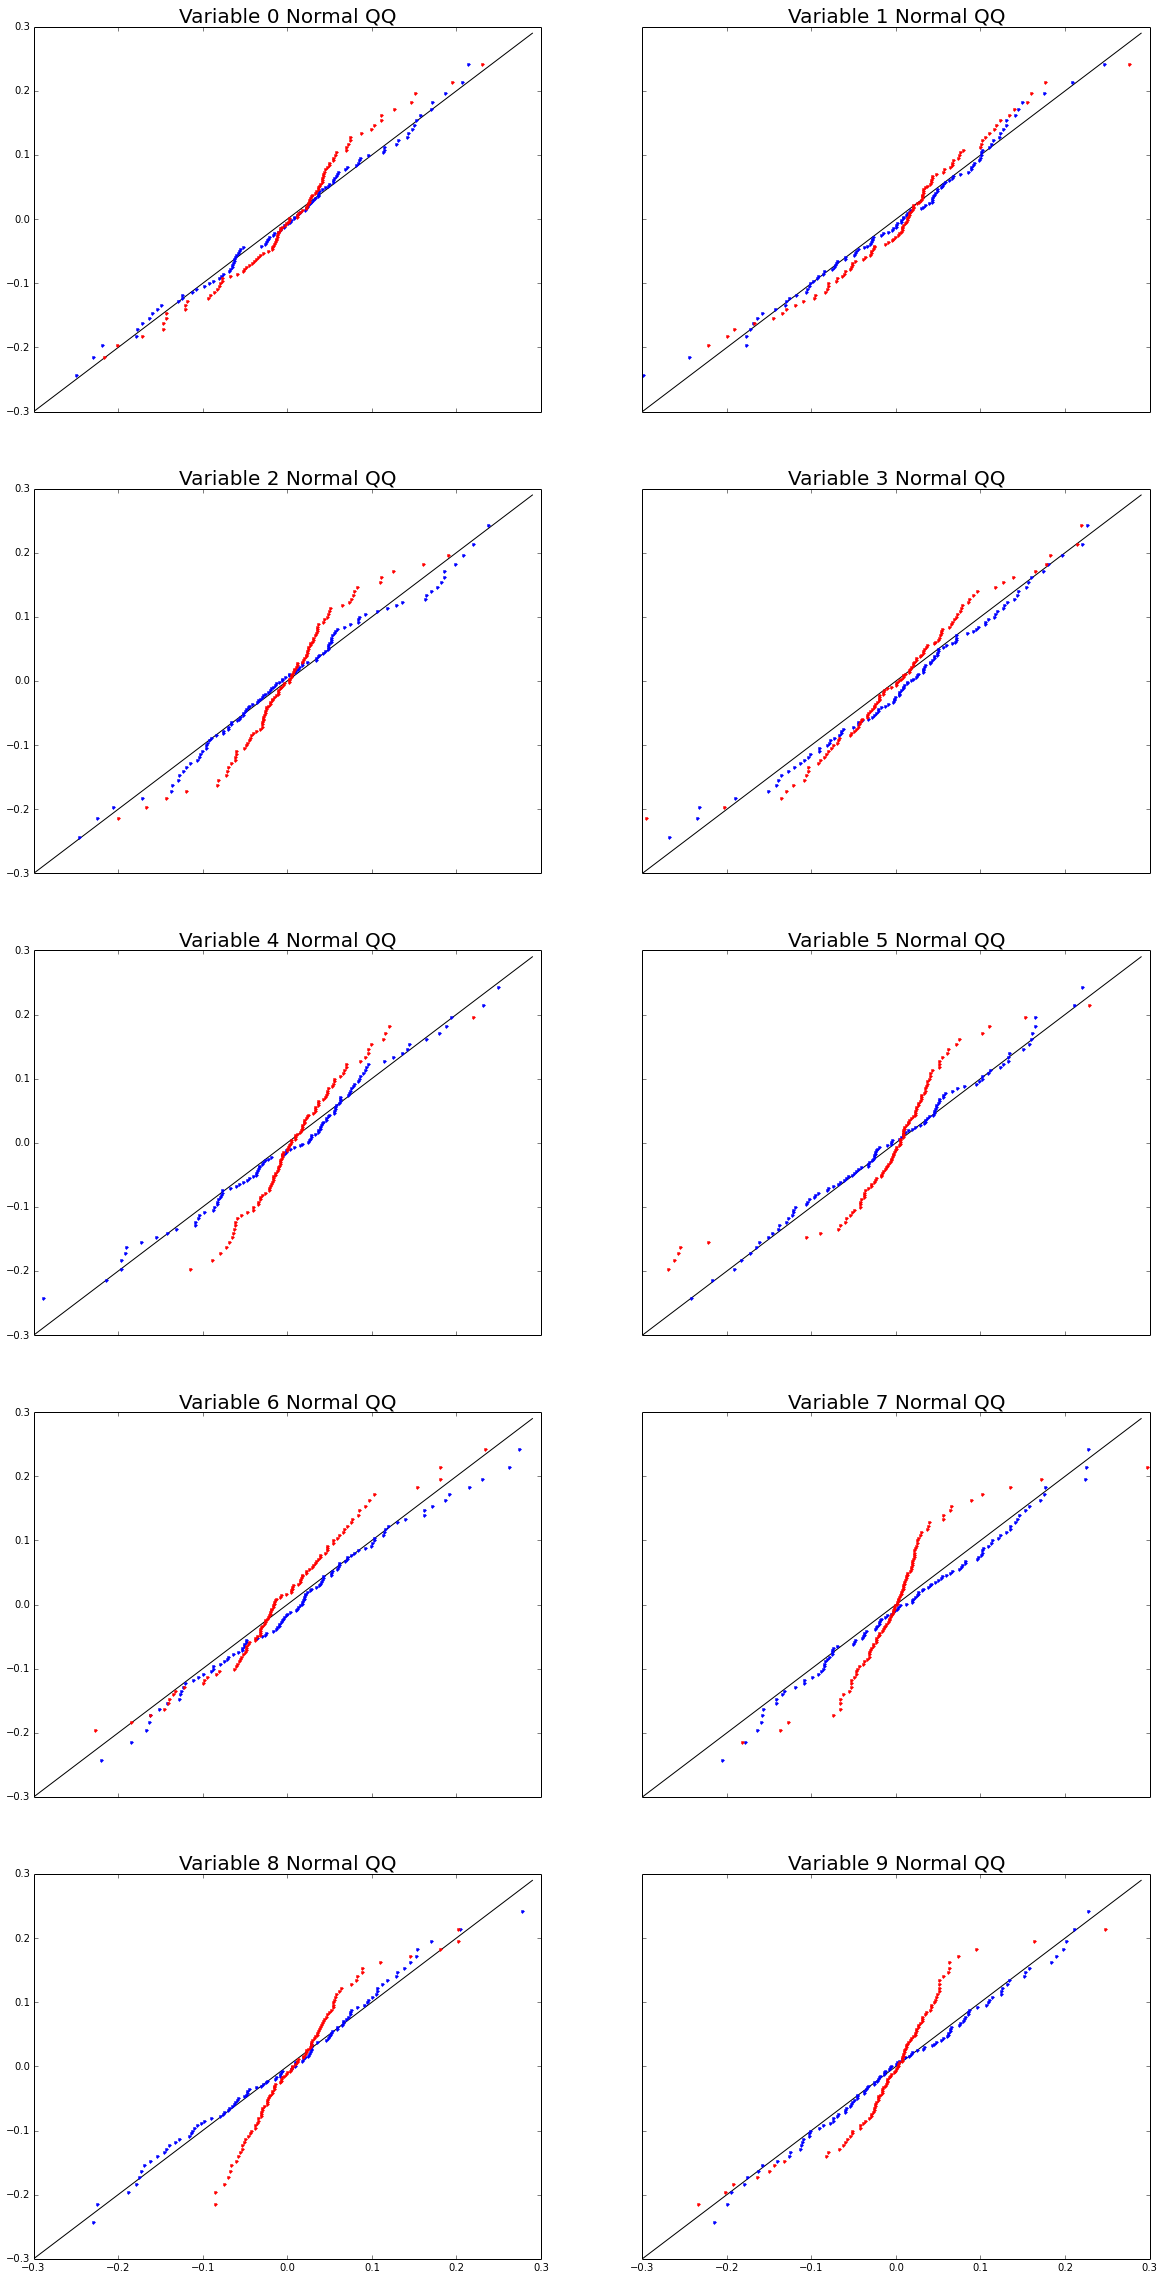

In [54]:
f,subplts = plt.subplots(5,2, sharex=True,sharey=True)
f.set_size_inches(20,40)
normal_quantiles = spstat.norm.ppf(np.arange(1/101,101/101,1/101))
normal_quantiles /= nplin.norm(normal_quantiles,axis=0)
line = np.arange(-.3,.3,.01)

for i in range(10):
    subplts[i//2,i%2].set_title('Variable %d Normal QQ' % i,fontdict={'fontsize':20 })
    subplts[i//2,i%2].set_xlim(-.3,.3)
    subplts[i//2,i%2].set_ylim(-.3,.3)
    subplts[i//2,i%2].plot(line,line,'k-')
    subplts[i//2,i%2].plot(np.sort(kologit.X[:,i])   ,normal_quantiles,'b.')
    subplts[i//2,i%2].plot(np.sort(kologit.X_ko[:,i]),normal_quantiles,'r.')